In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, welch
from utils import cut_bvp
from constants import Timestamps, expressive


In [2]:
base_path_video = "BVPs"

failed_masks = [
    [2, "Q1_1"],
    [52, "Q7_2"],
    [53, "Q4_2"]
]

paths = [
    "Q1_1",
    "Q1_2",
    # "Q2_1",
    # "Q2_2",
    # "Q3_1",
    # "Q3_2",
    # "Q4_1",
    # "Q4_2",
    # "Q5_1",
    # "Q5_2",
    # "Q6_1",
    # "Q6_2",
    # "Q7_1",
    # "Q7_2",
    # "Q8_1",
    # "Q8_2",
    "Q9_1",
    "Q9_2"
]

patients = list(range(1, 62))
patients.remove(23)

#patients = expressive

In [3]:
class BVP:
    def __init__(self, patient, path, signal, features):
        self.patient = patient
        self.path = path
        self.signal = signal
        self.features = features

In [4]:
#Test timestamps
for path in paths:

    t_start, t_end = getattr(Timestamps, path)

    print(t_start, t_end, "...........", t_end - t_start)

14 19 ........... 5
24 29 ........... 5
15 20 ........... 5
13 18 ........... 5


In [5]:
fs = 60

BVPs = []

for patient in patients:

    for path in paths:

        if [patient, path] in failed_masks:
            print(f"Skipping Patient_{patient}, {path}")
            continue

        data = np.load(f"{base_path_video}/Patient_{patient}/{path}.npy")

        t_start, t_end = getattr(Timestamps, path)

        data_cut = cut_bvp(data, t_start, t_end, fs)

        bvp = BVP(patient, path, data_cut, [])

        BVPs.append(bvp)

        #print(f"Patient_{patient}, {path}: {data.shape}")

print(f"Loaded {len(BVPs)} BVP signals")

Skipping Patient_2, Q1_1
Loaded 239 BVP signals


In [6]:
def get_peaks(bvp, fs):
    """
    Detect heart beats from BVP.
    distance ensures physiological HR range.
    """
    peaks, _ = find_peaks(
        bvp,
        distance=int(fs * 0.4)  # max 150 bpm
    )
    return peaks


In [7]:
def time_domain_features(bvp, fs):
    peaks = get_peaks(bvp, fs)

    if len(peaks) < 2:
        return None

    # RR intervals (seconds)
    rr = np.diff(peaks) / fs

    features = {}

    # Heart Rate
    features["HR_mean"] = 60 / np.mean(rr)
    features["HR_std"]  = np.std(60 / rr)

    # HRV features
    features["RMSSD"] = np.sqrt(np.mean(np.diff(rr) ** 2))
    features["SDNN"]  = np.std(rr)

    # pNN50
    features["pNN50"] = np.sum(np.abs(np.diff(rr)) > 0.05) / len(rr)

    return features


In [8]:
def frequency_domain_features(bvp, fs):
    peaks = get_peaks(bvp, fs)

    if len(peaks) < 4:
        print("Too small:", len(peaks))
        return None

    rr = np.diff(peaks) / fs
    rr_times = np.cumsum(rr)

    # Interpolate RR series
    rr_interp_time = np.linspace(rr_times[0], rr_times[-1], len(rr))
    rr_interp = np.interp(rr_interp_time, rr_times, rr)

    freqs, psd = welch(rr_interp, fs=4.0)

    lf_band = (freqs >= 0.04) & (freqs < 0.15)
    hf_band = (freqs >= 0.15) & (freqs < 0.4)

    lf = np.trapezoid(psd[lf_band], freqs[lf_band])
    hf = np.trapezoid(psd[hf_band], freqs[hf_band])

    features = {
        "LF": lf,
        "HF": hf,
        "LF_HF": lf / hf if hf > 0 else 0
    }

    return features


c:\Users\paqui\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\signal\_spectral_py.py:600: UserWarning: nperseg = 256 is greater than input length  = 6, using nperseg = 6
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


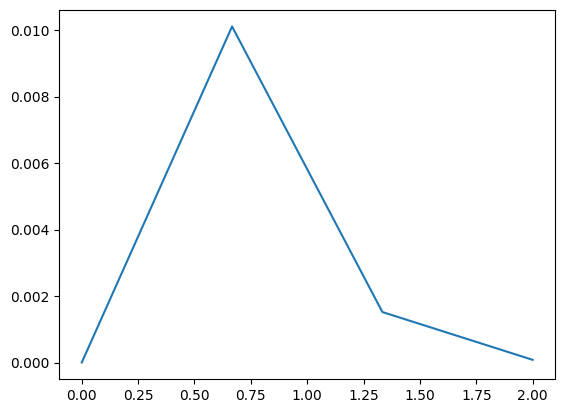

In [9]:
bvp, fs = BVPs[0].signal, 60

peaks = get_peaks(bvp, fs)

if len(peaks) < 4:
    print("Too small:", len(peaks))

rr = np.diff(peaks) / fs
rr_times = np.cumsum(rr)

# Interpolate RR series
rr_interp_time = np.linspace(rr_times[0], rr_times[-1], len(rr))
rr_interp = np.interp(rr_interp_time, rr_times, rr)

freqs, psd = welch(rr_interp, fs=4.0)

plt.plot(freqs, psd)

lf_band = (freqs >= 0.04) & (freqs < 0.15)
hf_band = (freqs >= 0.15) & (freqs < 0.4)

lf = np.trapezoid(psd[lf_band], freqs[lf_band])
hf = np.trapezoid(psd[hf_band], freqs[hf_band])

features = {
    "LF": lf,
    "HF": hf,
    "LF_HF": lf / hf if hf > 0 else 0
}

In [10]:
def morphological_features(bvp, fs):
    peaks = get_peaks(bvp, fs)

    if len(peaks) < 2:
        return None

    amplitudes = bvp[peaks]

    features = {
        "Pulse_amp_mean": np.mean(amplitudes),
        "Pulse_amp_std":  np.std(amplitudes)
    }

    return features


In [11]:
def extract_features_from_bvp(bvp, fs):
    feats = {}

    td = time_domain_features(bvp, fs)
    #fd = frequency_domain_features(bvp, fs)
    md = morphological_features(bvp, fs)

    if td is None or md is None: #or fd is None
        return None

    feats.update(td)
    #feats.update(fd)
    feats.update(md)

    return feats


In [21]:
fs = 60

valid = []

failed = []

failed_masks = [
    [2, "Q1_1"],
    [52, "Q7_2"],
    [53, "Q4_2"]
]

for bvp in BVPs:
    
    feats = extract_features_from_bvp(bvp.signal, fs)

    if feats is None or feats == []:
        # Do nothing
        print(f"Failed: Patient_{bvp.patient}, {bvp.path}")
        BVPs.remove(bvp)
        continue
    
    bvp.features = feats

    valid.append(f"Patient_{bvp.patient}, {bvp.path}")

print(f"Extracted features for {len(valid)} videos")


Extracted features for 238 videos


In [22]:
label_map = {
    "Q1": 1.0,
    "Q2": 1.0,
    "Q3": 1.0,
    "Q4": 0.0,
    "Q5": 0.0, 
    "Q6": 0.0,
    "Q7": -1.0,
    "Q8": -1.0,
    "Q9": -1.0
}

def get_label(path):
    q = path.split("_")[0]  # "Q3_2" → "Q3"
    return label_map[q]



In [23]:
for bvp in BVPs:

    try: 

        for feat, val in bvp.features.items():
            #print(feat, val)
            i = 1
        #print(bvp.patient, bvp.path, "Success")

    except Exception as e:
        print(bvp.patient, bvp.path, e)


In [24]:
# import numpy as np

# X = []
# y = []

# for bvp in BVPs:
#     if bvp is None or bvp.features is []:
#         print("Error: Patient", bvp.patient, bvp.path)
#         continue

#     feat_values = list(bvp.features.values())
#     X.append(feat_values)
#     y.append(get_label(bvp.path))
    

# X = np.array(X)
# y = np.array(y)

# print(X.shape, y.shape)
# print(np.unique(y, return_counts=True))
# print("Example of data: ", X[0])


LEARNING

In [16]:
# # Random Split

#from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(
#     X, y,
#     test_size=0.2,
#     stratify=y,      # important for emotions
#     random_state=42
# )

# print(X_train.shape, y_train.shape)
# print(X_test.shape, y_test.shape)

# print("Example of data: ", X_train[0])


In [25]:
# Expressive for test


X_train = []
y_train = []

X_test = []
y_test = []

for bvp in BVPs:
    if bvp is None or bvp.features == []:
        print("Fatal Error: Patient", bvp.patient, bvp.path)
        continue

    elif bvp.patient in expressive:
        #print(bvp.patient, bvp.path, "EXPRESSIVE")
        X_train.append(list(bvp.features.values()))
        y_train.append(get_label(bvp.path))

    else:
        #print(bvp.patient, bvp.path, bvp.features, "REST")
        X_test.append(list(bvp.features.values()))
        y_test.append(get_label(bvp.path))

X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)


print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

print("Example of data: ", X_train[0])

(80, 7) (80,)
(158, 7) (158,)
Example of data:  [8.74493927e+01 3.05153999e+01 2.40601099e-01 1.81408243e-01
 5.00000000e-01 1.21906164e-01 8.70925070e-02]


In [26]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)


In [ ]:
# from sklearn.linear_model import LogisticRegression

# clf = LogisticRegression(
#     max_iter=1000,
#     class_weight="balanced"  # helpful for imbalance
# )

# clf.fit(X_train, y_train)


In [27]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)



RandomForestRegressor(n_estimators=300, n_jobs=-1, random_state=42)

In [28]:
y_pred = model.predict(X_test)


In [ ]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
from scipy.stats import pearsonr

mae  = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
corr, _ = pearsonr(y_test, y_pred)
+
print(f"MAE  : {mae:.3f}")
print(f"RMSE : {rmse:.3f}")
print(f"Pearson r: {corr:.3f}")


MAE  : 1.007
RMSE : 1.077
Pearson r: -0.016


In [32]:
def continuous_to_discrete(y, th=0.33):
    return np.where(
        y < -th, -1,
        np.where(y > th, 1, 0)
    )

y_pred_cls = continuous_to_discrete(y_pred)
y_test_cls = continuous_to_discrete(y_test)


In [33]:
from sklearn.metrics import classification_report

print(classification_report(y_test_cls, y_pred_cls))


              precision    recall  f1-score   support

          -1       0.47      0.17      0.25        80
           0       0.00      0.00      0.00         0
           1       0.42      0.22      0.29        78

    accuracy                           0.20       158
   macro avg       0.30      0.13      0.18       158
weighted avg       0.45      0.20      0.27       158



c:\Users\paqui\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\paqui\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\paqui\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

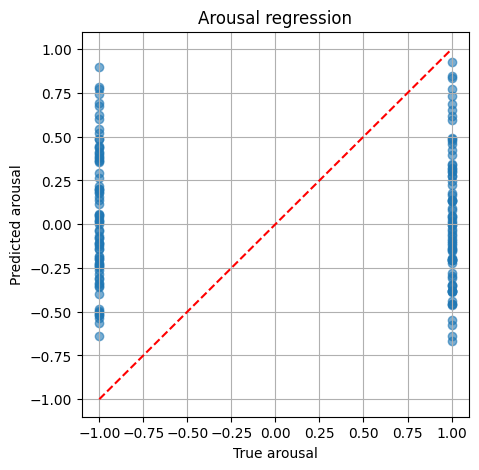

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([-1,1], [-1,1], 'r--')
plt.xlabel("True arousal")
plt.ylabel("Predicted arousal")
plt.title("Arousal regression")
plt.grid(True)
plt.show()
